In [208]:
# Import the necessary packages for the whole script
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, Independent, TransformedDistribution
from torch.distributions.transforms import TanhTransform
import gymnasium as gym
import mujoco
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import minari
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from matplotlib.patches import Ellipse


device = "cuda" if torch.cuda.is_available() else "cpu"

In [209]:
# According to the paper, each layer contains 256 neurons
NUM_NEURONS = 256
# The dimension of the abstract skill variable, z
Z_DIM = 256

# Skill Posterior, q_phi
class SkillPosterior(nn.Module):
    """
    Input: sequence of skills and actions
    Output: mean and std over z

    1. Linear layer w/ ReLU activation for the state sequence
    2. Single-layer bidirectional GRU for embedded states and action sequence (concatenated)
    3. Extract mean and std of layer 2's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.bi_gru = nn.GRU(input_size=NUM_NEURONS+self.action_dim, hidden_size= NUM_NEURONS//2, bidirectional=True, batch_first=True)
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)

    def forward(self, state_sequence, action_sequence):
        embedded_states = self.relu(self.fc1(state_sequence))
        concatenated = torch.cat([embedded_states, action_sequence], dim=-1)
        x, _ = self.bi_gru(concatenated) # [B, T, NUM_NEURONS]
        seq_emb = x.mean(dim=1) # [B, NUM_NEURONS]
        mean = self.mean.forward(seq_emb)
        std = self.std.forward(seq_emb)
        return mean, std
        # can also use single directional gru and take final hidden state

# Low-Level Skill-Conditioned Policy, pi_theta
class SkillPolicy(nn.Module):
    """
    Input: Current state and a skill, z
    Output: mean and std over a

    1. 2-layer shared network w/ ReLU activations for the state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim, action_dim):
        super().__init__()
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.action_dim)
        self.std = StandardDeviationNetwork(self.action_dim)
    
    def forward(self, state, z):
        c = torch.cat([state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std
        

# Temporally-Abstract World Model, p_psi
class TAWM(nn.Module):
    """
    Input: initial state, along with the abstract skill
    Output: mean and std over terminal state

    1. 2-layer shared network w/ ReLU activations for initial state and abstract skill (concatenated)
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim+Z_DIM, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(self.state_dim)
        self.std = StandardDeviationNetwork(self.state_dim)
    
    def forward(self, input_state, z):
        c = torch.cat([input_state, z], dim=-1)
        x = self.relu(self.fc1(c))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

# Skill Prior, p_omega
class SkillPrior(nn.Module):
    """
    Input: Initial state, s0, in the trajectory
    Output: mean and std over the abstract skill, z

    1. 2-layer shared network w/ ReLU activations for the initial state
    2. Extract mean and std of layer 1's output
    """
    def __init__(self, state_dim):
        super().__init__()

        self.state_dim = state_dim
        self.fc1 = nn.Linear(in_features=self.state_dim, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.relu = nn.ReLU()
        self.mean = MeanNetwork(Z_DIM)
        self.std = StandardDeviationNetwork(Z_DIM)
    
    def forward(self, input_state):
        x = self.relu(self.fc1(input_state))
        x = self.relu(self.fc2(x))
        mean = self.mean(x)
        std = self.std(x)
        return mean, std

class MeanNetwork(nn.Module):
    """
    Input: tensor to calculate mean
    Output: mean of input w/ dimension out_dim

    1. 2-layer network w/ ReLU activation for the first layer
    """
    def __init__(self, out_dim):
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=NUM_NEURONS, out_features=NUM_NEURONS)
        self.fc2 = nn.Linear(in_features=NUM_NEURONS, out_features=out_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        
        
class StandardDeviationNetwork(nn.Module):
    """
    Input: tensor to calculate std
    Output: std of input w/ dimension out_dim

    Note: the standard deviation is lower and upper bounded at 0.05 and 2.0
    - if std is 0, then log(std) -> inf
    - if std is large, then can affect training

    1. 2-layer linear network with ReLU activation after first layer and softplus after second

    """
    def __init__(self, out_dim, min_std=0.05, max_std=5.0):
        super().__init__()
        self.fc1 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, out_dim)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        self.min_std = min_std
        self.max_std = max_std
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        std = self.softplus(x) 
        #+ self.min_std  # lower bound
        #std = torch.clamp(std, max=self.max_std)
        return std


In [212]:


# Load and save the model to a .pth file
def save_checkpoint(path, q_phi, pi_theta, p_psi, p_omega):
    ckpt = {
        "q_phi": q_phi.state_dict(),
        "pi_theta": pi_theta.state_dict(),
        "p_psi": p_psi.state_dict(),
        "p_omega": p_omega.state_dict(),
        "S_stats": {"mean": S_mean, "std": S_std},
        "config": dict(B=B, T=T, Z_DIM=Z_DIM, NUM_NEURONS=NUM_NEURONS,device=str(device))
    }
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save(ckpt, path)
    print(f"checkpoint saved -> {path}")

def load_checkpoint(path, q_phi, pi_theta, p_psi, p_omega, strict=True):
    ckpt = torch.load(path, weights_only=False)
    q_phi.load_state_dict(ckpt["q_phi"], strict=strict)
    pi_theta.load_state_dict(ckpt["pi_theta"], strict=strict)
    p_psi.load_state_dict(ckpt["p_psi"], strict=strict)
    p_omega.load_state_dict(ckpt["p_omega"], strict=strict)
    stats = ckpt.get("S_stats", None)
    if stats is not None:
        global S_mean, S_std
        S_mean, S_std = stats["mean"], stats["std"]
    print(f"[checkpoint] loaded <- {path}")
    return ckpt

# save_checkpoint("checkpoints/antmaze_em_unclamped_40.pth", q_phi, pi_theta, p_psi, p_omega)
# B, the number of subtrajectories per batch (from paper)
B = 100

# T, the length of each subtrajectory (from paper)
T = 39

# AntMaze state and action dims (from Minari)
state_dim = 29
action_dim = 8
q_phi = SkillPosterior(state_dim=state_dim, action_dim=action_dim).to(device)
pi_theta = SkillPolicy(state_dim=state_dim, action_dim=action_dim).to(device)
p_psi = TAWM(state_dim=state_dim).to(device)
p_omega = SkillPrior(state_dim=state_dim).to(device)

_ = load_checkpoint("checkpoints/antmaze_em_unclamped_40_65.pth", q_phi, pi_theta, p_psi, p_omega)
q_phi.eval(); pi_theta.eval(); p_psi.eval(); p_omega.eval()

ant_maze_dataset = minari.load_dataset('D4RL/antmaze/medium-play-v1')


[checkpoint] loaded <- checkpoints/antmaze_em_unclamped_40_65.pth


/Users/williamhuang/anaconda3/envs/oposm/lib/python3.10/site-packages/minari/dataset/minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.6 does not meet the requirement <=3.1.6,>=3.1.1.
We recommend to install the required version with `pip install "mujoco>=3.1.1,<=3.1.6"`
  warnings.warn(


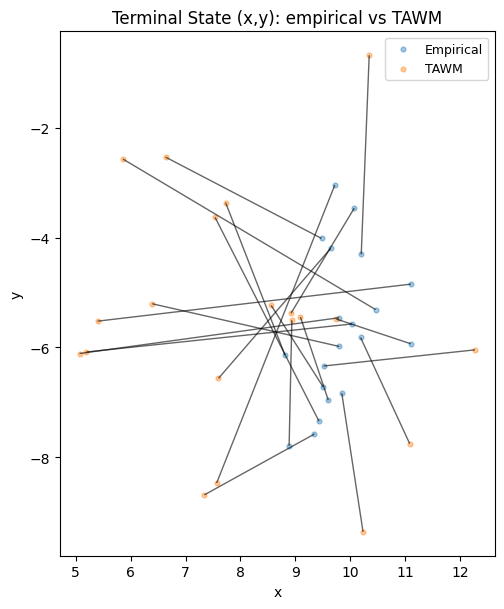

<Figure size 640x480 with 0 Axes>

In [275]:
def to_torch(x):
    return torch.as_tensor(x, dtype=torch.float32, device=device)

def policy_dist(mu, std):
    # build a tanh-squashed normal action dist
    base = Independent(Normal(mu, std.clamp_min(0.05)), 1) # clamps std to be at least 0.05 to prevent exploding/vanishing gradients
    return TransformedDistribution(base, [TanhTransform(cache_size=1)]) # Creates a Independent Normal over action dims applied Tanh Transform to map actions to (-1, 1)

def standardize_state(s): 
    return (s - S_mean) / S_std

def unstandardize_state(s):
    return s * S_std + S_mean

def pack_state_from_obs(obs):
    """
    Build 29-d state (observation + achieved goal).
    Take in env obs (which contains both "observation" and "achieved goal").
    """
    obs_vec = np.asarray(obs["observation"], dtype=np.float32).ravel()
    ag = np.asarray(obs.get("achieved_goal", obs_vec[:2]), dtype=np.float32).ravel()

    state = np.concatenate([obs_vec.astype(np.float32), ag.astype(np.float32)], 0) # Combines the 27-d and 2-d tensors
    return obs_vec.astype(np.float32), ag.astype(np.float32), state

def get_sim_handles(env):
    """Unwraps Gym wrappers to access MuJoCo model and data to work with qpos/qvel and forward dynamics. 
    Return (unwrapped MuJoCo environment, MuJoCo model, muJoCo data)"""
    t = env
    for attr in ["env", "unwrapped"]: # for the current env, replace env with env.env and then find env.env.unwrapped
        if hasattr(t, attr):
            t = getattr(t, attr)
    # t should now be the innermost env and grab the MuJoCo data and model
    # sim = getattr(t, "sim", None)
    # if sim is not None and hasattr(sim, "model") and hasattr(sim, "data"):
    #     return t, sim.model, sim.data
    
    # CHECK THIS
    if hasattr(t, "model") and hasattr(t, "data"):
        return t, t.model, t.data

def split_obs_to_qpos_qvel(s0_obs, s0_ag, env):
    """Split dataset obs into qpos and qvel to reset physics. Need to provide exact qpos and qvel to reset dataset state"""
    _, model, data = get_sim_handles(env)
    nq, nv = int(model.nq), int(model.nv)  # Ant: typically 15, 14

    s0_obs = np.asarray(s0_obs, np.float32).ravel()
    s0_ag  = np.asarray(s0_ag,  np.float32).ravel()

    qpos = data.qpos.ravel().copy()
    qvel = data.qvel.ravel().copy()

    # fill exact slices
    qpos[0:2] = s0_ag
    qpos[2:nq] = s0_obs[:(nq - 2)]
    qvel[:nv] = s0_obs[(nq - 2):(nq - 2 + nv)]

    return qpos.astype(np.float32), qvel.astype(np.float32)

def read_antmaze_obs(env):
    """Reconstruct AntMaze dict-observation from MuJoCo state."""
    t = env
    for attr in ("env", "unwrapped"):
        if hasattr(t, attr):
            t = getattr(t, attr)
    qpos = t.data.qpos.ravel()
    qvel = t.data.qvel.ravel()
    obs27 = np.concatenate([qpos[2:], qvel]).astype(np.float32)
    ag2 = qpos[:2].astype(np.float32)
    return {"observation": obs27, "achieved_goal": ag2}

def set_env_state(env, qpos, qvel):
    """Write qpos/qvel into MuJoCo and forward."""
    _, model, data = get_sim_handles(env)
    # Set the physical state
    data.qpos[:] = qpos
    data.qvel[:] = qvel
    # Required step after makeing a manual state change
    mujoco.mj_forward(model, data)

def recover_ant_env():
    return ant_maze_dataset.recover_environment()


def plot_pairs(emp_xy, taw_xy, title="", fixed_limits=(-10, 10, -10, 10)):
    """
    Draw segments from empirical to TAWM endpoints.
    """

    # Use all points
    E, P = emp_xy, taw_xy
    segs = np.stack([E, P], axis=1)  

    fig, ax = plt.subplots(figsize=(6.2, 6.2))
    ax.scatter(emp_xy[:, 0], emp_xy[:, 1], s=12, alpha=0.4, label="Empirical")
    ax.scatter(taw_xy[:, 0], taw_xy[:, 1], s=12, alpha=0.4, label="TAWM")
    ax.add_collection(LineCollection(segs, linewidths=1.0, colors="k", alpha=0.6))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend(loc="best", fontsize=9)

    # xmin, xmax, ymin, ymax = fixed_limits
    # ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    all_xy = np.vstack([emp_xy, taw_xy])
    pad = 0.05 * (all_xy.max(0) - all_xy.min(0) + 1e-9)
    ax.set_xlim(all_xy[:,0].min()-pad[0], all_xy[:,0].max()+pad[0])
    ax.set_ylim(all_xy[:,1].min()-pad[1], all_xy[:,1].max()+pad[1])
    plt.tight_layout(); plt.show()

    plt.tight_layout()
    plt.show()



@torch.no_grad()
def sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=300, seed=0):
    """
    Reset to same physical s0 (qpos,qvel), then for each rollout:
      - read env dict-obs after reset
      - build s0 from that obs, sample z ~ p_omega(z|s0)
      - roll H steps with pi_theta under that z
    Also sample TAWM endpoints from p_psi(s_T|s0,z) for the SAME (s0,z).
    """
    H = 40

    # physical MuJoCo properties for the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, s0_ag_ds, env)

    emp_xy, taw_xy = [], []

    p_omega.eval(); p_psi.eval(); pi_theta.eval()

    for _ in range(N_rollouts):
        # Refresh MuJoCo episode bookkeeping
        env.reset() 

        # Reset the start state
        set_env_state(env, s0_qpos, s0_qvel)

        # get the actual obs from the env of the start state
        obs = read_antmaze_obs(env)

        # get the combined state and standardize
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # sample  a skill from from the skill prior at this s0
        mu_pr, std_pr = p_omega(s0_t)
        z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0) 

        # roll T steps with low-level policy (pi_theta(a|s, z)) with sampled skill
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            # Build and standardize curr state
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)

            # Get the action distribution
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))

            # Sample an action from the tanh-squashed normal
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            
            # Take a step with the action
            cur_obs, _, term, trunc, _ = env.step(a)
            if term or trunc:
                break

        # empirical terminal (x,y) from the last obs
        _, ag_emp, _ = pack_state_from_obs(cur_obs)
        emp_xy.append(ag_emp.copy())

        # Query world model p_psi(s_T | s0, z) to get mean and std 
        mu_T, std_T = p_psi(s0_t, z.unsqueeze(0)) 
        # Sample a terminal state and unstandardize
        sT_std = mu_T + (std_T) * torch.randn_like(mu_T)
        sT = unstandardize_state(sT_std.squeeze(0).cpu().numpy())
        
        taw_xy.append(sT[-2:].copy())

    return np.stack(emp_xy, 0), np.stack(taw_xy, 0)

env = recover_ant_env()

i = 0
# find a dataset start 
for ep in ant_maze_dataset.iterate_episodes():
    if i > 20 and len(ep.observations["observation"]) >= T + 1:
        s0_obs_ds = ep.observations["observation"][0].astype(np.float32)   # 27-d
        s0_ag_ds  = ep.observations["achieved_goal"][0].astype(np.float32) # 2-d
        break
    i += 1

emp_xy, taw_xy = sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=20, seed=42)

plot_pairs(emp_xy, taw_xy, title="Terminal State (x,y): empirical vs TAWM")



/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_40353/4252969958.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", len(trajs_xy))


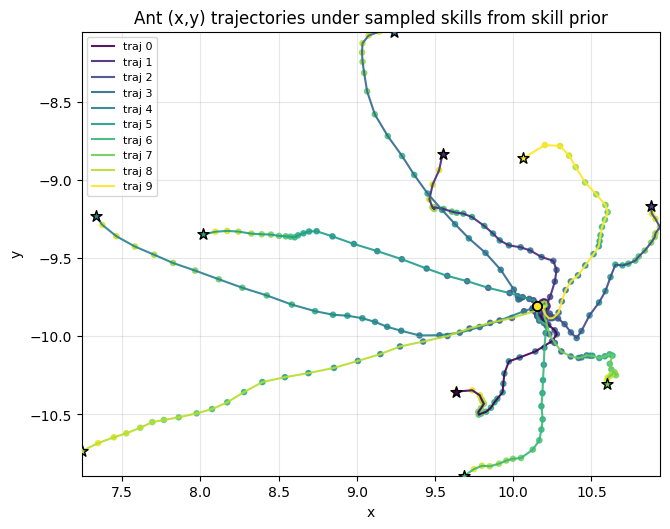

In [322]:
@torch.no_grad()
def sample_tawm_predictions(s0_env, z, N_samples=200):
    """Sample predicted terminal states from p_psi(s_T | s0, z)."""
    s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)
    mu_T, std_T = p_psi(s0_t, z.unsqueeze(0))  # [1, state_dim]
    dist = Independent(Normal(mu_T, std_T), 1)
    sT_samples_std = dist.sample((N_samples,)).squeeze(1).cpu().numpy()
    sT_samples = unstandardize_state(sT_samples_std)
    xy_samples = sT_samples[:, -2:] # the achieved_goal part
    return xy_samples
    
@torch.no_grad()
def rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds=None, N_trajs=3, horizon=T, seed=0,
    resample_skill_per_traj=True, # new z each traj if True, other wise same z for all traj
    use_prior=True, # if False, pass z explicitly
    z_fixed=None, # z to pass in
):
    """
    This function resets the env to the same physical start state (excluding xy), samples a skill z from the skill prior p_omega(z|s0).
    Then, it executes the low level policy pi_theta(a|s, z) for T steps
    Plots the path of the trajectory over the T steps for each trajectory.
    """
    H = horizon

    # Extract the qpos and qvel of the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, s0_ag_ds, env)

    trajs_xy, zs_used = [], []

    # Precompute z if we want the same skill for all trajectories
    z_global = None
    if not resample_skill_per_traj:
        # Obtain env s0 (dict obs) once and sample z from prior at that exact s0
        env.reset()
        set_env_state(env, s0_qpos, s0_qvel)

        # Get the actual obs from the env of the start state
        obs = read_antmaze_obs(env)

        
        # Combine the obs and the xy location
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Use fixed if provided, otherwise just sample a skill
        if z_fixed is not None:
            z_global = z_fixed.to(device).detach().clone().squeeze(0)
        elif use_prior:
            mu_pr, std_pr = p_omega(s0_t)
            z_global = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)

    for k in range(N_trajs):
        env.reset()
        # Reset sim to the same physical start
        set_env_state(env, s0_qpos, s0_qvel)

        obs = read_antmaze_obs(env)

        _, ag0, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Choose skill for this trajectory
        if resample_skill_per_traj:
            if z_fixed is not None:
                z = z_fixed.to(device).detach().clone().squeeze(0)
            elif use_prior:
                mu_pr, std_pr = p_omega(s0_t)
                z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)
        else:
            z = z_global

        zs_used.append(z.detach().cpu())

        # Rollout and collect (x,y) at each step using pi_theta(a|s, z)
        xy = [ag0.copy()]
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))
            # a = torch.tanh(a_mu).squeeze(0).cpu().numpy().astype(np.float32)
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            cur_obs, _, term, trunc, _ = env.step(a)
            _, ag_t, _ = pack_state_from_obs(cur_obs)
            xy.append(ag_t.copy())
            if term or trunc:
                break

        trajs_xy.append(np.stack(xy, axis=0))

    return trajs_xy, zs_used, s0_env


def plot_xy_trajectories(trajs_xy, title=""):
    """
    Plots each trajectory as a polyline with start plotted as circle, end as star
    """
    fig, ax = plt.subplots(figsize=(6.8, 6))

    # Choose colors for each trajectory
    colors = cm.get_cmap("viridis", len(trajs_xy))

    # Plot each of the trajectories 
    for i, xy in enumerate(trajs_xy):
        c = colors(i)# set the color for the trajectory
        ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c, label=f"traj {i}") # draw the path
        ax.scatter(xy[0,0],  xy[0,1],  s=40, marker='o', color=c, edgecolor='k', zorder=3) # draw the start
        ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3) # draw the end
        tcolors = np.linspace(0, 1, len(xy)) 
        ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8) # points along trajectory get brighter

    ax.set_aspect('equal', 'box')
    all_xy = np.concatenate(trajs_xy, axis=0)
    lo = all_xy.min(axis=0)
    hi = all_xy.max(axis=0)
    ax.set_xlim(lo[0], hi[0])
    ax.set_ylim(lo[1], hi[1])
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best", fontsize=8)
    plt.tight_layout()
    plt.show()

trajs_xy, zs_used, s0_env = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
    N_trajs=10,    
    horizon=30, # same T trained p_psi on
    seed=123,
    resample_skill_per_traj=False, 
    use_prior=True                 
)

plot_xy_trajectories(trajs_xy, title="Ant (x,y) trajectories under sampled skills from skill prior")


/var/folders/wp/q7yyy4ls2m3bvyscgh359t0r0000gn/T/ipykernel_40353/4252969958.py:102: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("viridis", len(trajs_xy))


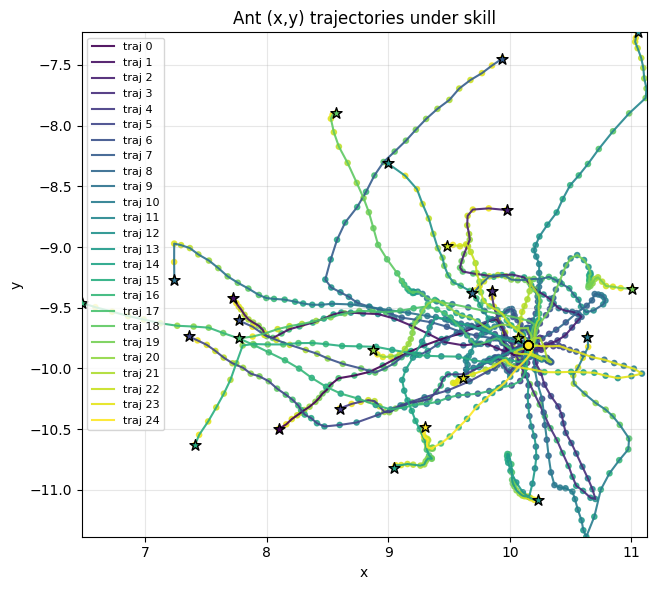

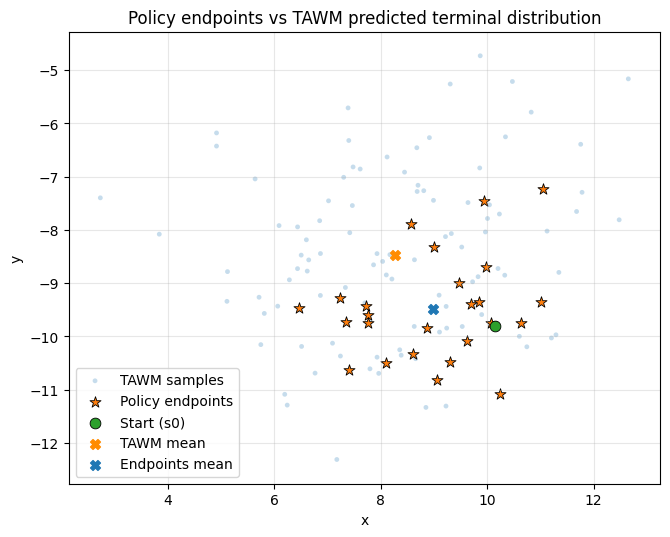

In [326]:
def endpoints_from_trajs(trajs_xy):
    """Return N x 2 array of final (x,y)"""
    return np.stack([traj[-1] for traj in trajs_xy], axis=0)

def plot_endpoints_vs_tawm(trajs_xy, xy_samples, s0_xy=None, title="Endpoints vs TAWM"):
    """
    Compare the distribution of terminal (x,y) endpoints with TAWM predicted samples.
    """
    fig, ax = plt.subplots(figsize=(6.8, 6))

    end_xy = endpoints_from_trajs(trajs_xy)           
    ax.scatter(xy_samples[:,0], xy_samples[:,1],
               s=12, alpha=0.25, edgecolors='none', label="TAWM samples")
    ax.scatter(end_xy[:,0], end_xy[:,1],
               s=70, marker='*', edgecolor='k', linewidths=0.6, label="Policy endpoints")

    ax.scatter([s0_xy[0]], [s0_xy[1]], s=60, c='tab:green', marker='o',
               edgecolor='k', linewidths=0.6, label="Start (s0)")

    cov_pred = np.cov(xy_samples.T)
    mean_pred = xy_samples.mean(axis=0)
    ax.scatter([mean_pred[0]], [mean_pred[1]], c='darkorange', s=50, marker='X', label="TAWM mean")

    cov_end = np.cov(end_xy.T) if len(end_xy) > 2 else np.eye(2) * 1e-3
    mean_end = end_xy.mean(axis=0)
    ax.scatter([mean_end[0]], [mean_end[1]], c='tab:blue', s=50, marker='X', label="Endpoints mean")

    all_pts = np.vstack([xy_samples, end_xy, s0_xy[None,:]])
    lo, hi = all_pts.min(axis=0), all_pts.max(axis=0)
    pad = 0.06 * (hi - lo + 1e-9)
    ax.set_xlim(lo[0]-pad[0], hi[0]+pad[0])
    ax.set_ylim(lo[1]-pad[1], hi[1]+pad[1])

    ax.set_aspect('equal', 'box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")

    plt.tight_layout()
    plt.show()

i = 0
index = 10
# find a dataset start 
for ep in ant_maze_dataset.iterate_episodes():
    if i == index and len(ep.observations["observation"]) >= T + 1:
        s0_obs_ds = ep.observations["observation"][0].astype(np.float32)  
        s0_ag_ds  = ep.observations["achieved_goal"][0].astype(np.float32) 
        break
    i += 1

trajs_xy, zs_used, s0_env = rollout_xy_trajectories(
    env, s0_obs_ds, s0_ag_ds,
    N_trajs=25, horizon=40, seed=123,
    resample_skill_per_traj=False, use_prior=True
)

xy_pred_samples = sample_tawm_predictions(s0_env, zs_used[0], N_samples=100)

plot_xy_trajectories(trajs_xy, title="Ant (x,y) trajectories under skill")

plot_endpoints_vs_tawm(
    trajs_xy, xy_pred_samples,
    s0_xy=trajs_xy[0][0],
    title="Policy endpoints vs TAWM predicted terminal distribution"
)



/Users/williamhuang/anaconda3/envs/oposm/lib/python3.10/site-packages/minari/dataset/minari_dataset.py:204: UserWarning: Installed mujoco version 3.3.6 does not meet the requirement <=3.1.6,>=3.1.1.
We recommend to install the required version with `pip install "mujoco>=3.1.1,<=3.1.6"`
  warnings.warn(


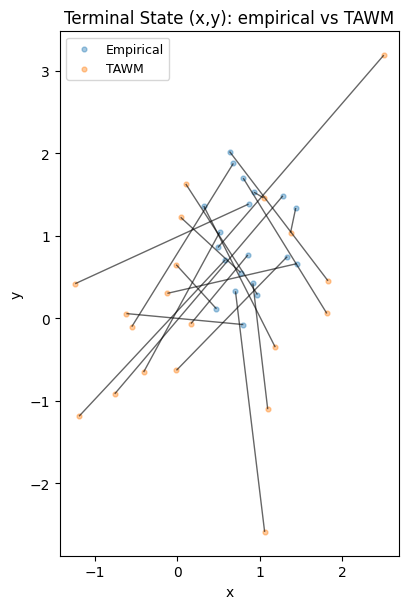

<Figure size 640x480 with 0 Axes>

In [213]:
def to_torch(x):
    return torch.as_tensor(x, dtype=torch.float32, device=device)

def policy_dist(mu, std):
    # build a tanh-squashed normal action dist
    base = Independent(Normal(mu, std.clamp_min(0.05)), 1) # clamps std to be at least 0.05 to prevent exploding/vanishing gradients
    return TransformedDistribution(base, [TanhTransform(cache_size=1)]) # Creates a Independent Normal over action dims applied Tanh Transform to map actions to (-1, 1)

def standardize_state(s): 
    return (s - S_mean) / S_std

def unstandardize_state(s):
    return s * S_std + S_mean

def pack_state_from_obs(obs):
    """
    Build 29-d state (observation + achieved goal).
    Take in env obs (which contains both "observation" and "achieved goal").
    """
    obs_vec = np.asarray(obs["observation"], dtype=np.float32).ravel()
    ag = np.asarray(obs.get("achieved_goal", obs_vec[:2]), dtype=np.float32).ravel()

    state = np.concatenate([obs_vec.astype(np.float32), ag.astype(np.float32)], 0) # Combines the 27-d and 2-d tensors
    return obs_vec.astype(np.float32), ag.astype(np.float32), state

def get_sim_handles(env):
    """Unwraps Gym wrappers to access MuJoCo model and data to work with qpos/qvel and forward dynamics. 
    Return (unwrapped MuJoCo environment, MuJoCo model, muJoCo data)"""
    t = env
    for attr in ["env", "unwrapped"]: # for the current env, replace env with env.env and then find env.env.unwrapped
        if hasattr(t, attr):
            t = getattr(t, attr)
    # t should now be the innermost env and grab the sim attribute which contains the MuJoCo data and model
    # sim = getattr(t, "sim", None)
    # if sim is not None and hasattr(sim, "model") and hasattr(sim, "data"):
    #     return t, sim.model, sim.data
    
    # CHECK THIS
    if hasattr(t, "model") and hasattr(t, "data"):
        return t, t.model, t.data

def split_obs_to_qpos_qvel(s0_obs, env):
    """Split dataset obs into qpos and qvel to reset physics. Need to provide exact qpos and qvel to reset dataset state"""
    _, model, data = get_sim_handles(env)
    nq, nv = int(model.nq), int(model.nv) # number of position and velocity entries required for env MuJoCo model
    # s0_obs = np.asarray(s0_obs, dtype=np.float32).ravel()
    # qpos_raw = s0_obs[:nq]
    # qvel_raw = s0_obs[nq:nq+nv]

    # CHECK THIS
    # qpos = np.zeros(nq, dtype=np.float32)
    # qpos = qpos[:min(nq, qpos_raw.size)] = qpos_raw[:min(nq, qpos_raw.size)]
    # qvel = np.zeros(nv, dtype=np.float32)
    # qvel[:min(nv, qvel_raw.size)] = qvel_raw[:min(nv, qvel_raw.size)]
    # return qpos, qvel
    # Start from a known-valid state (after reset)
    qpos = data.qpos.ravel().copy()
    qvel = data.qvel.ravel().copy()

    o = np.asarray(s0_obs, np.float32).ravel()

    kq = min(nq, max(0, o.size))            
    kv = min(nv, max(0, o.size - nq))       

    if kq > 0:
        qpos[:kq] = o[:kq]
    if kv > 0:
        qvel[:kv] = o[nq:nq+kv]
    return qpos.astype(np.float32), qvel.astype(np.float32)
def set_env_state(env, qpos, qvel):
    """Write qpos/qvel into MuJoCo and forward."""
    _, model, data = get_sim_handles(env)
    # Set the physical state
    data.qpos[:] = qpos
    data.qvel[:] = qvel
    # Required step after makeing a manual state change
    mujoco.mj_forward(model, data)

def recover_ant_env():
    return ant_maze_dataset.recover_environment()


def plot_pairs(emp_xy, taw_xy, title="", fixed_limits=(-10, 10, -10, 10)):
    """
    Draw segments from empirical to TAWM endpoints.
    """

    # Use all points
    E, P = emp_xy, taw_xy
    segs = np.stack([E, P], axis=1)  

    fig, ax = plt.subplots(figsize=(6.2, 6.2))
    ax.scatter(emp_xy[:, 0], emp_xy[:, 1], s=12, alpha=0.4, label="Empirical")
    ax.scatter(taw_xy[:, 0], taw_xy[:, 1], s=12, alpha=0.4, label="TAWM")
    ax.add_collection(LineCollection(segs, linewidths=1.0, colors="k", alpha=0.6))

    ax.set_aspect("equal", "box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title(title)
    ax.legend(loc="best", fontsize=9)

    # xmin, xmax, ymin, ymax = fixed_limits
    # ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    all_xy = np.vstack([emp_xy, taw_xy])
    pad = 0.05 * (all_xy.max(0) - all_xy.min(0) + 1e-9)
    ax.set_xlim(all_xy[:,0].min()-pad[0], all_xy[:,0].max()+pad[0])
    ax.set_ylim(all_xy[:,1].min()-pad[1], all_xy[:,1].max()+pad[1])
    plt.tight_layout(); plt.show()

    plt.tight_layout()
    plt.show()



@torch.no_grad()
def sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=300, seed=0):
    """
    Reset to same physical s0 (qpos,qvel), then for each rollout:
      - read env dict-obs after reset
      - build s0 from that obs, sample z ~ p_omega(z|s0)
      - roll H steps with pi_theta under that z
    Also sample TAWM endpoints from p_psi(s_T|s0,z) for the SAME (s0,z).
    """
    H = 40

    # physical MuJoCo properties for the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, env)

    emp_xy, taw_xy = [], []

    for _ in range(N_rollouts):
        # Refresh MuJoCo episode bookkeeping
        env.reset() 

        # Reset the start state
        set_env_state(env, s0_qpos, s0_qvel)

        # get the actual obs from the env of the start state
        zero_act = np.zeros((env.action_space.shape[0],), dtype=np.float32)
        obs, _, _, _, _ = env.step(zero_act)

        # get the combined state and standardize
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # sample  a skill from from the skill prior at this s0
        mu_pr, std_pr = p_omega(s0_t)
        z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0) 

        # roll T steps with low-level policy (pi_theta(a|s, z)) with sampled skill
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            # Build and standardize curr state
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)

            # Get the action distribution
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))

            # Sample an action from the tanh-squashed normal
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            
            # Take a step with the action
            cur_obs, _, term, trunc, _ = env.step(a)
            if term or trunc:
                break

        # empirical terminal (x,y) from the last obs
        _, ag_emp, _ = pack_state_from_obs(cur_obs)
        emp_xy.append(ag_emp.copy())

        # Query world model p_psi(s_T | s0, z) to get mean and std 
        mu_T, std_T = p_psi(s0_t, z.unsqueeze(0)) 
        # Sample a terminal state and unstandardize
        sT_std = mu_T + (std_T) * torch.randn_like(mu_T)
        sT = unstandardize_state(sT_std.squeeze(0).cpu().numpy())
        
        taw_xy.append(sT[-2:].copy())

    return np.stack(emp_xy, 0), np.stack(taw_xy, 0)

env = recover_ant_env()

# find a dataset start 
i = 0
for ep in ant_maze_dataset.iterate_episodes():
    if i != 0 and len(ep.observations["observation"]) >= T + 1:
        s0_obs_ds = ep.observations["observation"][0].astype(np.float32)   # 27-d
        s0_ag_ds  = ep.observations["achieved_goal"][0].astype(np.float32) # 2-d
        break
    i += 1

emp_xy, taw_xy = sample_skill_and_roll(env, s0_obs_ds, s0_ag_ds, N_rollouts=20, seed=42)

plot_pairs(emp_xy, taw_xy, title="Terminal State (x,y): empirical vs TAWM")



In [242]:
@torch.no_grad()
def sample_tawm_predictions(s0_env, z, N_samples=200):
    """Sample predicted terminal states from p_psi(s_T | s0, z)."""
    s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)
    mu_T, std_T = p_psi(s0_t, z.unsqueeze(0))  # [1, state_dim]
    dist = Independent(Normal(mu_T, std_T), 1)
    sT_samples_std = dist.sample((N_samples,)).squeeze(1).cpu().numpy()
    sT_samples = unstandardize_state(sT_samples_std)
    xy_samples = sT_samples[:, -2:]  # the achieved_goal part
    return xy_samples

def draw_cov_ellipse(ax, mean, cov, n_std=2.0, **kwargs):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=theta, fill=False, **kwargs)
    ax.add_patch(ellip)

@torch.no_grad()
def rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds=None, N_trajs=3, horizon=T, seed=0,
    resample_skill_per_traj=True, # new z each traj if True, other wise same z for all traj
    use_prior=True, # if False, pass z explicitly
    z_fixed=None, # z to pass in
):
    """
    This function resets the env to the same physical start state (excluding xy), samples a skill z from the skill prior p_omega(z|s0).
    Then, it executes the low level policy pi_theta(a|s, z) for T steps
    Plots the path of the trajectory over the T steps for each trajectory.
    """
    H = horizon

    # Extract the qpos and qvel of the chosen start state
    s0_qpos, s0_qvel = split_obs_to_qpos_qvel(s0_obs_ds, env)

    trajs_xy, zs_used = [], []

    # Precompute z if we want the same skill for all trajectories
    z_global = None
    if not resample_skill_per_traj:
        # Obtain env s0 (dict obs) once and sample z from prior at that exact s0
        env.reset()
        set_env_state(env, s0_qpos, s0_qvel)

        # Get the actual obs from the env of the start state
        zero_act = np.zeros((env.action_space.shape[0],), dtype=np.float32)
        obs, _, _, _, _ = env.step(zero_act)
        
        # Combine the obs and the xy location
        _, _, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Use fixed if provided, otherwise just sample a skill
        if z_fixed is not None:
            z_global = z_fixed.to(device).detach().clone().squeeze(0)
        elif use_prior:
            mu_pr, std_pr = p_omega(s0_t)
            z_global = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)

    for k in range(N_trajs):
        env.reset()
        # Reset sim to the same physical start
        set_env_state(env, s0_qpos, s0_qvel)

        zero_act = np.zeros((env.action_space.shape[0],), dtype=np.float32)
        obs, _, _, _, _ = env.step(zero_act)

        _, ag0, s0_env = pack_state_from_obs(obs)
        s0_t = to_torch(standardize_state(s0_env)).unsqueeze(0)

        # Choose skill for this trajectory
        if resample_skill_per_traj:
            if z_fixed is not None:
                z = z_fixed.to(device).detach().clone().squeeze(0)
            elif use_prior:
                mu_pr, std_pr = p_omega(s0_t)
                z = (mu_pr + std_pr * torch.randn_like(mu_pr)).squeeze(0)
        else:
            z = z_global

        zs_used.append(z.detach().cpu())

        # Rollout and collect (x,y) at each step using pi_theta(a|s, z)
        xy = [ag0.copy()]
        pi_theta.eval()
        cur_obs = obs
        for t in range(H):
            _, _, st = pack_state_from_obs(cur_obs)
            st_t = to_torch(standardize_state(st)).unsqueeze(0)
            a_mu, a_std = pi_theta(st_t, z.unsqueeze(0))
            a = policy_dist(a_mu, a_std).sample().squeeze(0).cpu().numpy().astype(np.float32)
            cur_obs, _, term, trunc, _ = env.step(a)
            _, ag_t, _ = pack_state_from_obs(cur_obs)
            xy.append(ag_t.copy())
            if term or trunc:
                break

        trajs_xy.append(np.stack(xy, axis=0))

    return trajs_xy, zs_used, s0_env


# def plot_xy_trajectories(trajs_xy, title="", xy_samples = None):
#     """
#     Plots each trajectory as a polyline with start plotted as circle, end as star
#     """
#     fig, ax = plt.subplots(figsize=(6.8, 6))

#     # Choose colors for each trajectory
#     colors = cm.get_cmap("viridis", len(trajs_xy))

#     # Plot each of the trajectories 
#     for i, xy in enumerate(trajs_xy):
#         c = colors(i)# set the color for the trajectory
#         ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c, label=f"traj {i}") # draw the path
#         ax.scatter(xy[0,0],  xy[0,1],  s=40, marker='o', color=c, edgecolor='k', zorder=3) # draw the start
#         ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3) # draw the end
#         tcolors = np.linspace(0, 1, len(xy)) 
#         ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8) # points along trajectory get brighter
#     if xy_samples is not None:
#         ax.scatter(
#             xy_samples[:, 0],
#             xy_samples[:, 1],
#             c='orange',
#             s=15,
#             alpha=0.25,
#             label="TAWM samples"
#         )
#         # Optionally draw covariance ellipse
#         cov = np.cov(xy_samples.T)
#         mean = xy_samples.mean(axis=0)
#         draw_cov_ellipse(ax, mean, cov, edgecolor='darkorange', lw=2, alpha=0.7)
        
#     ax.set_aspect('equal', 'box')
#     all_xy = np.concatenate(trajs_xy, axis=0)
#     lo = all_xy.min(axis=0)
#     hi = all_xy.max(axis=0)
#     ax.set_xlim(lo[0], hi[0])
#     ax.set_ylim(lo[1], hi[1])
#     ax.set_xlabel("x")
#     ax.set_ylabel("y")
#     ax.set_title(title)
#     ax.grid(True, alpha=0.3)
#     # ax.legend(loc="best", fontsize=8)
#     plt.tight_layout()
#     plt.show()
def plot_xy_trajectories(trajs_xy, title="", xy_samples=None):
    fig, ax = plt.subplots(figsize=(6.8, 6))
    colors = cm.get_cmap("viridis", len(trajs_xy))

    for i, xy in enumerate(trajs_xy):
        c = colors(i)
        ax.plot(xy[:,0], xy[:,1], '-', lw=1.5, alpha=0.9, color=c)
        ax.scatter(xy[0,0], xy[0,1], s=40, marker='o', color=c, edgecolor='k', zorder=3)
        ax.scatter(xy[-1,0], xy[-1,1], s=70, marker='*', color=c, edgecolor='k', zorder=3)
        tcolors = np.linspace(0, 1, len(xy))
        ax.scatter(xy[:,0], xy[:,1], c=tcolors, cmap="viridis", s=14, alpha=0.8)

    if xy_samples is not None:
        ax.scatter(
            xy_samples[:, 0], xy_samples[:, 1],
            s=18, alpha=0.35, c='orange', edgecolors='none', zorder=2, label="TAWM samples"
        )
        cov = np.cov(xy_samples.T)
        mean = xy_samples.mean(axis=0)
        draw_cov_ellipse(ax, mean, cov, edgecolor='darkorange', lw=2, alpha=0.9)

    # ----- bounds: include samples if provided -----
    all_xy = np.concatenate(trajs_xy, axis=0)
    if xy_samples is not None:
        all_xy = np.vstack([all_xy, xy_samples])
    lo, hi = all_xy.min(axis=0), all_xy.max(axis=0)
    pad = 0.05 * (hi - lo + 1e-9)
    ax.set_xlim(lo[0]-pad[0], hi[0]+pad[0])
    ax.set_ylim(lo[1]-pad[1], hi[1]+pad[1])

    ax.set_aspect('equal', 'box')
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_title(title)
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
    plt.tight_layout(); plt.show()


trajs_xy, zs_used, s0_env = rollout_xy_trajectories(env, s0_obs_ds, s0_ag_ds,
    N_trajs=25,    
    horizon=40, # same T trained p_psi on
    seed=123,
    resample_skill_per_traj=False, 
    use_prior=True                 
)

xy_pred_samples = sample_tawm_predictions(s0_env, zs_used[0], N_samples=500)

plot_xy_trajectories(trajs_xy, title="Ant (x,y) trajectories under sampled skills from skill prior", xy_samples=xy_pred_samples)


TypeError: split_obs_to_qpos_qvel() missing 1 required positional argument: 'env'